# Analysis of the fluorescence recovery

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```

In [35]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# filelist: /path/to/the/file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

[Text(0.5, 0, 'Time p.i. [min]'),
 Text(0, 0.5, '% max GFP intensity around Gondi vacuole')]

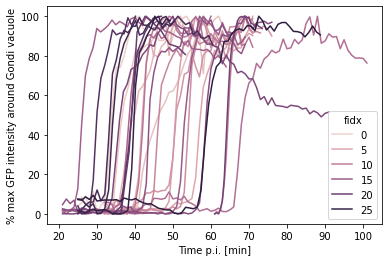

In [52]:
filelist = pd.read_csv(config['filelist'])
folder = Path(config['filelist']).parent
df = []
for k,row in enumerate(filelist.iloc):
    path = folder / row['Filename'].replace('.tif','-profile.csv')    
    tmp = pd.read_csv(path)
    tmp['fidx'] = k
    tmp['file'] = row['Filename']
    x = tmp['Mean intensity']
    tmp['Normalized intensity'] = 100 * (x - x.min()) / (x.max() -x.min())
    m = tmp['Model']
    tmp['Normalized model'] = 100 * (m - m.min()) / (m.max() - m.min())
    df.append(tmp)
df = pd.concat(df,ignore_index=True)
sns.lineplot(data=df, x='Time [min]', y='Normalized intensity', hue='fidx')
plt.gca().set(xlabel='Time p.i. [min]',ylabel='% max GFP intensity around Gondi vacuole')

<AxesSubplot:xlabel='Time [min]', ylabel='Normalized model'>

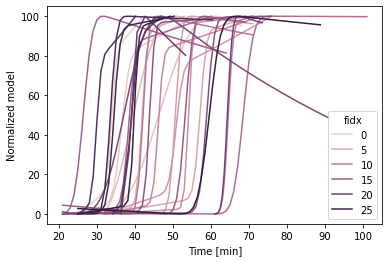

In [53]:
sns.lineplot(data=df, x='Time [min]', y='Normalized model', hue='fidx')

## Interpolated time points

In [54]:
t = np.linspace(20,120,2*(100-20)+1)
dst = {}
dst['Time'] = t
for n,g in df.groupby('file'):            
    tg = g['Time [min]']
    fg =  g['Mean intensity']
    dst[n] = np.interp(t, tg, fg)

ptable = pd.DataFrame(dst)
ptable

,Time,Parasite10_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 4)-1.tif,Parasite11_231129_24MIN_1min_2.nd2 - 231129_24MIN_1min_2.nd2 (series 4)-1.tif,Parasite12_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 1)-1.tif,Parasite13_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 1)-1.tif,Parasite14_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 1)-1.tif,Parasite15_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 2)-1.tif,Parasite16_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 2)-1.tif,Parasite17_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 3)-1.tif,Parasite18_231204_244_30MIN_1min_2002.nd2 - 231204_244_30MIN_1min_2002.nd2 (series 4)-1.tif,...,Parasite26_231212_244_19MIN_1min_.nd2 - 231212_244_19MIN_1min_.nd2 (series 4)-1.tif,Parasite27_231212_244_19MIN_1min_.nd2 - 231212_244_19MIN_1min_.nd2 (series 5)-1.tif,Parasite2_from video on manuscript_211013_GFPRNF_RHtomato_1hmin_30s008-1.tif,Parasite3_211013_GFPRNF_RHtomato_30min_2min001.nd2 - 211013_GFPRNF_RHtomato_30min_2min001.nd2 (series 04)-1.tif,Parasite4_211013_GFPRNF_RHtomato_30min_2min001.nd2 - 211013_GFPRNF_RHtomato_30min_2min001.nd2 (series 04)-1.tif,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 1)-1.tif,Parasite6_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 1)-1.tif,Parasite7_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 2)-1.tif,Parasite8_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 2)-1.tif,Parasite9_231129_23MIN_1min.nd2 - 231129_23MIN_1min.nd2 (series 3)-1.tif
0,20.000,227.339411,152.306620,111.717117,120.653285,112.420930,131.918330,120.976364,124.417874,114.733696,...,114.240385,117.844720,108.313964,121.096702,119.859108,175.667461,192.947083,151.565789,134.201671,146.68331
1,20.625,227.339411,152.306620,111.717117,120.653285,112.420930,131.918330,120.976364,124.417874,114.733696,...,114.240385,117.844720,108.313964,121.096702,119.859108,175.667461,192.947083,151.565789,134.201671,146.68331
2,21.250,227.339411,152.306620,111.717117,120.653285,112.420930,131.918330,120.976364,124.417874,114.733696,...,114.070970,117.904790,108.313964,121.096702,119.859108,175.667461,192.947083,151.565789,134.201671,146.68331
3,21.875,227.339411,152.306620,111.717117,120.653285,112.420930,131.918330,120.976364,124.417874,114.733696,...,113.646272,118.055296,108.313964,121.096702,119.859108,175.667461,192.947083,151.565789,134.201671,146.68331
4,22.500,227.339411,152.306620,111.717117,120.653285,112.420930,131.918330,120.976364,124.417874,114.733696,...,113.114391,117.847559,108.313964,121.096702,119.859108,175.667461,192.947083,151.565789,134.201671,146.68331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,117.500,350.093085,242.062139,195.670000,185.516667,198.428023,245.127273,206.032258,209.766129,203.591633,...,249.404946,274.858243,139.441399,149.884657,158.458295,349.532798,378.689826,309.617729,276.400773,278.05643
157,118.125,350.093085,242.062139,195.670000,185.516667,198.428023,245.127273,206.032258,209.766129,203.591633,...,249.404946,274.858243,139.441399,149.884657,158.458295,349.532798,378.689826,309.617729,276.400773,278.05643
158,118.750,350.093085,242.062139,195.670000,185.516667,198.428023,245.127273,206.032258,209.766129,203.591633,...,249.404946,274.858243,139.441399,149.884657,158.458295,349.532798,378.689826,309.617729,276.400773,278.05643
159,119.375,350.093085,242.062139,195.670000,185.516667,198.428023,245.127273,206.032258,209.766129,203.591633,...,249.404946,274.858243,139.441399,149.884657,158.458295,349.532798,378.689826,309.617729,276.400773,278.05643


<AxesSubplot:xlabel='5%-95% recovery time [min]', ylabel='Count'>

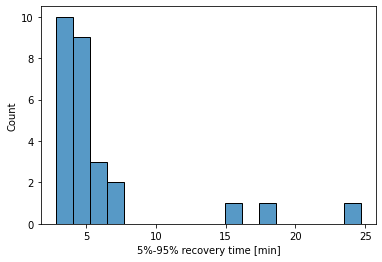

In [55]:
ds = pd.read_csv(config['summary'])
sns.histplot(ds, x='5%-95% recovery time [min]')

<AxesSubplot:xlabel='Photo-bleaching [min]', ylabel='Count'>

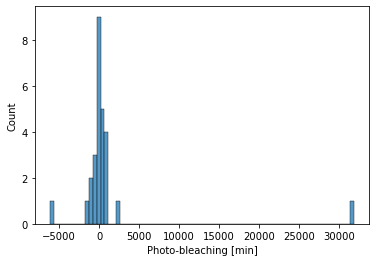

In [41]:
sns.histplot(ds, x='Photo-bleaching [min]')

In [79]:
ds[ds['5%-95% recovery time [min]']> 10]

,Image,Start time [min],First frame,Time mid point [min],Time constant [min],5%-95% recovery time [min],Intensity amplitude [au],Intensity offset [au],Photo-bleaching [min],R squared
2,Parasite12_231204_244_30MIN_1min_2002.nd2 - 23...,30,1,47.050491,10.601704,24.659563,79.250795,203.678017,181.965927,0.977050
3,Parasite13_231204_244_30MIN_1min_2002.nd2 - 23...,30,1,39.552973,7.742210,18.008380,54.237335,178.684568,245.792665,0.981827
18,Parasite27_231212_244_19MIN_1min_.nd2 - 231212...,19,1,37.816468,6.879310,16.001276,288.550404,433.079350,88.529766,0.974918
